# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2023/24 (6 CFU) - Dr. Jacopo Pegoraro,  Dr. Riccardo Mazzieri, Dr. Daniele Mari
---

## Lab. 08 - Self Supervised Learning

This notebook is an adaptation of this tutorial provided by Google Research: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb

Here, the authors implement and train all the models with PyTorch Lightning, while we will use vanilla PyTorch instead. Feel free to check this out if you are interested.


In this Laboratory class, we will implement an example of *self-supervised contrastive learning*.

Self-supervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way. However, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.
The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available. The subfield that we will focus on in this tutorial is contrastive learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_contrastive_learning.png?raw=1" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way. Let's first start with importing our standard libraries below:

In [1]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms


# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

C:\Users\giuse\AppData\Local\Temp\ipykernel_13416\2894411316.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

Note that in this Laboratory session some training procedures will require several hours to be run until convergence. For this reason, **you will also have pre-trained models available to download**, so that you will be able to continue the lab even if your model was not fully trained.

Note that those models are slightly larger as normal (~100MB overall) since we use the default ResNet-18 architecture. If you are running this notebook locally, make sure to have sufficient disk space available.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
                    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
                    "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## SimCLR

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such. Next, we implement the SimCLR architecture, and finally train it on a large, unlabeled dataset.

### Data Augmentation for Contrastive Learning

To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [3]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. **The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR** since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_data_augmentations.png?raw=1" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: **crop-and-resize, and color distortion**. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/crop_views.svg?raw=1" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features. If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. **Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.**

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup. Follow the links to the official documentation pages to implement this set of transforms in the below cell.

 - [Random horizontal flip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html), with `p=0.5`;  
 - [Crop-and-resize](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html), with `size=96`;
 - [Color distortion](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html), with parameters `0.5, 0.5, 0.5, 0.1` for brightness, contrast, saturation and hue respectively. This transformation must be applied randomly with probability `p=0.8`. To do so, put this transformation inside a [Random Apply](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomApply.html) transform;
 - [Random grayscale](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomGrayscale.html), with `p=0.2`;
 - [Gaussian blur](https://pytorch.org/vision/main/generated/torchvision.transforms.GaussianBlur.html) with `kernel_size=9`.

 In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). In our experiments, this setting obtained better performance and was faster and more stable to train. If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial since the model can't rely on this information anymore to distinguish between images.

In [4]:
contrast_transforms = transforms.Compose([torchvision.transforms.RandomHorizontalFlip(p = 0.5), # Horizontal flip
                                          torchvision.transforms.RandomResizedCrop(size = 96), # Random crop
                                          torchvision.transforms.RandomApply(
                                            [torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)],
                                            p=0.5), # Color distorsion
                                          torchvision.transforms.RandomGrayscale(p=0.2), # Random grayscale
                                          torchvision.transforms.GaussianBlur(kernel_size=9), # Gaussian blur
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

After discussing the data augmentation techniques, we can now focus on the dataset. In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers.

Luckily, the STL10 dataset is provided through torchvision. Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download. For our initial discussion of self-supervised learning and SimCLR, we will create two data loaders with our contrastive transformations above: the `unlabeled_data` will be used to train our model via contrastive learning, and `train_data_contrast` will be used as a validation set in contrastive learning.

In [5]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

torch.Size([12, 3, 96, 96])


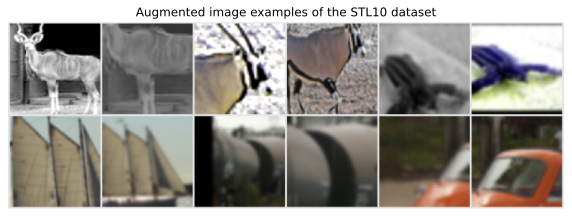

In [6]:
# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
print(imgs.shape)


img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_network_setup.svg?raw=1" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

We now define the `SimCLR` model in the next cell.
Our model will be composed of:
 - Our feature extractor, which will be a ResNet-18. It will return a tensor of dimension `hidden_dim * 4`;
 - A small final projection head, a small MLP composed of:
  - The ReLu activation function;
  - A linear layer with output shape equal to `hidden_dim`


Luckily you will not need to write the entire ResNet-18 model from scracth, as it is made available with the `torchvision` package. Use `torchvision.models.resnet18(num_classes=K)` to implement a ResNet-18 architecture with `K` output neurons. Please check the relative documentation for the more implementation details: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [7]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        k = hidden_dim*4    # The output of the base encoder is 4 times the hidden dimension size
        # Base model f(.), remember to put output shape equal to hidden_dim * 4
        self.convnet = torchvision.models.resnet18(num_classes = k)  # Output of last linear layer

        # The MLP for g(.) consists of Linear->ReLU->Linear
        # Note that the resnet18 model provided by torchvision already has a single linear output layer which you can access with convnet.fc
        # We will modify directly that module instead of creating a new one as a new variable
        # NOTE: It's important to follow this structure. This is because PyTorch stores the models' weights under a named dictionary.
        # If you define more modules with other names you will incur in an error when trying to load the weights of the pretrained model
        # later in the notebook.
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(True),
            nn.Linear(k, hidden_dim)
        )

    def forward(self, x):
        # Encode all images
        feats = self.convnet(x)
        return feats

### NT-Xent loss

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the NT-Xent loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the NT-Xent loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that. However, in this tutorial, we will restrict ourselves to the STL10 dataset where we use the task of image classification on STL10 as our test task.

In [8]:
def NT_Xent_loss(features_batch, temperature, mode='train'):
    """
    Takes in input a features_batch tensor of shape (BatchSize * 2, feature_dim), the temperature parameter,
    and computes the NT_Xent_loss
    """

    # Calculate cosine similarity between all possible couples of examples in the features_batch tensor
    # Result must be a (BatchSize*2, BatchSize*2) tensor
    # Hints:
    # 1) Check the documentation https://pytorch.org/docs/stable/generated/torch.nn.functional.cosine_similarity.html
    # 2) Use broadcasting!

    cos_sim = torch.nn.functional.cosine_similarity(features_batch.unsqueeze(1), features_batch.unsqueeze(0), dim=-1)

    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)

    # Find the positive example, we know that it is batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

    # NT_Xent loss
    cos_sim = cos_sim / temperature

    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Get ranking position of positive example
    comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                            cos_sim.masked_fill(pos_mask, -9e15)],
                            dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()

    return nll, acc_top1, acc_top5

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model.

Other than tracking the loss, we also track the top-5 accuracy metric, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to use for monitoring potential overfitting.

In [9]:
def train(model, device, train_loader, optimizer, lr_scheduler, epoch, loss_temperature, maxit=10):
    train_losses = []
    train_top5_accs = []

    model.train()
    model.to(device)
    for i, batch in enumerate(train_loader):
        imgs, _ = batch

        # Concatenate the two images along the batch dimension, so we get a tensor of shape (BatchDim * 2, 3, 96, 96)
        # Also remember to put the images on the GPU
        cat_imgs = torch.cat(imgs, dim=0).to(device)

        # Compute the features
        features = model(cat_imgs)

        # Compute the loss together with the accuracy metrics, and store them in the lists above
        nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, loss_temperature, mode='train')
        train_losses.append(nce_loss.item())
        train_top5_accs.append(acc_top5.item())

        # Backpropagate the loss and perform the optimization step
        optimizer.zero_grad()
        nce_loss.backward()
        optimizer.step()

        print(f"Train Epoch: {epoch}, Iteration: {i}/{len(train_loader)},  \tLoss: {nce_loss.item():.6f}, \tTop1_Acc: {acc_top1.item():.6f}, \tTop5_Acc: {acc_top5.item():.6f}")

        if i >= maxit:
            return np.mean(train_losses), np.mean(train_top5_accs)
            break

    lr_scheduler.step()
    return np.mean(train_losses), np.mean(train_top5_accs)

@torch.no_grad()
def valid(model, device, val_loader, epoch, loss_temperature, maxit=10):
    model.eval()
    val_losses = []
    val_top5_accs = []
    for i, batch in enumerate(val_loader):
        imgs, _ = batch

        # Concatenate the images
        imgs = torch.cat(imgs, dim=0).to(device)

        # Compute the features
        features = model(imgs)

        # Compute loss and accuracies, and store them
        nce_loss, acc_top1, acc_top5 = NT_Xent_loss(features, loss_temperature, mode='valid')
        val_losses.append(nce_loss.item())
        val_top5_accs.append(acc_top5.item())

        print(f"Valid Epoch: {epoch}, Iteration: {i}/{len(val_loader)},  \tLoss: {nce_loss.item():.6f}, \tTop1_Acc: {acc_top1.item():.6f}, \tTop5_Acc: {acc_top5.item():.6f}")
        if i >= maxit:
          return np.mean(val_losses), np.mean(val_top5_accs)
          break

    return np.mean(val_losses), np.mean(val_top5_accs)

Now that we have implemented the functions for the training and validation iterations, we are ready to write the full training loop.


A common observation in contrastive learning is that **the larger the batch size, the better the models perform**. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

**IMPORTANT NOTE:** Training the SimCLR to convergence would require a very long training session. For the sake of this laboratory, we will just run a much reduced training procedure with 10 epochs, where for each epoch we will train the model on only `maxit` batches. (Setting `maxit=10` this cell will take around 10 minutes to run, but feel free to set `maxit` to a bigger number if you can afford spending more time for the training procedure, or if you have access to more powerful computational resources).

For the next sections of the Laboratory you will be able to load the weights of a fully trained SimCLR model, to see its actual performances.



In [10]:
# Define training hyperparameters
batch_size=256
hidden_dim=128
temperature=0.07
weight_decay=1e-4
max_epochs=500
lr=2e-4

epochs = 10
maxit = 10

# Define Loaders
train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
# Define SimCLR Model
simclr_model = SimCLR(hidden_dim)

# Define Optimizer and Learning rate Scheduler
optimizer = optim.AdamW(simclr_model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min=lr/50)

# Training Loop
train_losses = []
val_losses = []
train_top5_accs = []
val_top5_accs = []

for epoch in range(epochs):
    # Training iterations and update lists
    train_loss, train_top5_acc = train(simclr_model, device, train_loader, optimizer, lr_scheduler, epoch, temperature, maxit)
    train_losses.append(train_loss)
    train_top5_accs.append(train_top5_acc)
    print()

    # Validation iterations
    val_loss, val_top5_acc = valid(simclr_model, device, val_loader, epoch, temperature, maxit)
    val_losses.append(val_loss)
    val_top5_accs.append(val_top5_acc)
    print()

# Save the model
torch.save(simclr_model.state_dict(), os.path.join(CHECKPOINT_PATH, 'My_SimCLR.ckpt'))

Train Epoch: 0, Iteration: 0/390,  	Loss: 6.186920, 	Top1_Acc: 0.013672, 	Top5_Acc: 0.025391
Train Epoch: 0, Iteration: 1/390,  	Loss: 6.049513, 	Top1_Acc: 0.021484, 	Top5_Acc: 0.066406
Train Epoch: 0, Iteration: 2/390,  	Loss: 6.101550, 	Top1_Acc: 0.021484, 	Top5_Acc: 0.044922
Train Epoch: 0, Iteration: 3/390,  	Loss: 5.881848, 	Top1_Acc: 0.037109, 	Top5_Acc: 0.105469
Train Epoch: 0, Iteration: 4/390,  	Loss: 5.759138, 	Top1_Acc: 0.031250, 	Top5_Acc: 0.085938
Train Epoch: 0, Iteration: 5/390,  	Loss: 5.855580, 	Top1_Acc: 0.044922, 	Top5_Acc: 0.105469
Train Epoch: 0, Iteration: 6/390,  	Loss: 5.686113, 	Top1_Acc: 0.033203, 	Top5_Acc: 0.091797
Train Epoch: 0, Iteration: 7/390,  	Loss: 6.046884, 	Top1_Acc: 0.021484, 	Top5_Acc: 0.060547
Train Epoch: 0, Iteration: 8/390,  	Loss: 5.673170, 	Top1_Acc: 0.050781, 	Top5_Acc: 0.121094
Train Epoch: 0, Iteration: 9/390,  	Loss: 5.664949, 	Top1_Acc: 0.044922, 	Top5_Acc: 0.125000
Train Epoch: 0, Iteration: 10/390,  	Loss: 5.634436, 	Top1_Acc: 0.0429

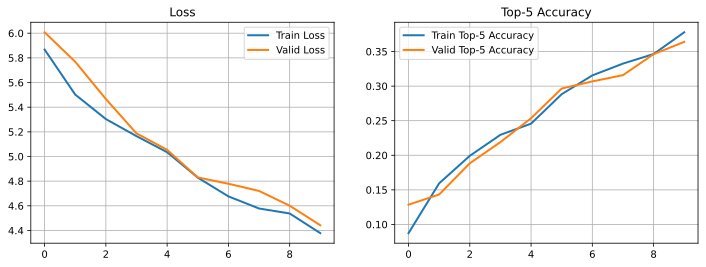

In [11]:
# Let's plot the training and validation losses and Top-5 Accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(val_losses, label='Valid Loss')

ax[1].plot(train_top5_accs, label='Train Top-5 Accuracy')
ax[1].plot(val_top5_accs, label='Valid Top-5 Accuracy')

ax[0].set_title('Loss')
ax[1].set_title('Top-5 Accuracy')

for i in range(2):
    ax[i].legend()
    ax[i].grid()

plt.show()

As you can see we have just scratched the surface of the full training session.

For running the next sections of this notebook, you can run the cell below to load the weights of the fully trained model. (You can ignore the cell instead if you  would like to test the model you personally trained).

In [12]:
## Load the pre-trained model here
## (Note: if you get an error here, you have some mistakes in the SimCLR model class definition.)
simclr_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt"))[ "state_dict"])

C:\Users\giuse\AppData\Local\Temp\ipykernel_31412\1637460622.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(os.path.join(CHECKPO

<All keys matched successfully>

To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/tensorboard_simclr.png?raw=1" width="1200px"></center>

One thing to note is that contrastive learning benefits a lot from long training. The shown plot above is from a training that took approximally 1 day on a NVIDIA TitanRTX. Training the model for even longer might reduce its loss further, but we did not experience any gains from it for the downstream task on image classification. In general, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available.

## Downstream classification task

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform classification on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple classification task setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [13]:
class SimpleClassifier(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.model(x)

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [14]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the classifier model.

In [15]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [16]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a function to train this simple classifier on the SimCLR features. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [20]:
def train_classifier(batch_size, train_feats_data, test_feats_data, feature_dim, max_epochs=100):

    # Define the simple classifier model here, the number of classes in the dataset is 10
    model = SimpleClassifier(feature_dim, 10)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    tlosses = []
    taccs = []

    best_test_acc = 0
    model.train()
    for epoch in range(max_epochs):
        losses = []
        accs = []
        for batch in train_loader:
            feats, labels = batch
            feats = feats.to(device)
            labels = labels.to(device)

            # Forward pass
            preds = model(feats)

            # Compute the cross entropy loss
            loss = F.cross_entropy(preds, labels)

            acc = (preds.argmax(dim=-1) == labels).float().mean()

            losses.append(loss.item())
            accs.append(acc.item())

            # Backpropagate the loss and perform the optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        tlosses.append(np.mean(losses))
        taccs.append(np.mean(accs))

        print(f"Epoch: {epoch}, Train Loss: {tlosses[-1]:.6f}, Train Accuracy: {taccs[-1]:.6f}")

        if epoch%10 == 0:
            ## Test set
            print()
            test_acc = []
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    feats, labels = batch
                    feats = feats.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    preds = model(feats)
                    acc = (preds.argmax(dim=-1) == labels).float().mean()
                    test_acc.append(acc.item())

                test_acc = np.mean(test_acc)
                if test_acc > best_test_acc:
                    best_test_acc = test_acc.item()
                else:
                    print("Early stop at epoch ", epoch)
                    break

    return model, best_test_acc

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [21]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [22]:
batch_size=64
feature_dim=train_feats_simclr.tensors[0].shape[1]
num_classes=10
lr=1e-3
weight_decay=1e-3

results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_classifier(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1])
    results[num_imgs_per_label] = small_set_results

Epoch: 0, Train Loss: 2.422734, Train Accuracy: 0.102431

Epoch: 1, Train Loss: 2.171760, Train Accuracy: 0.228299
Epoch: 2, Train Loss: 2.016439, Train Accuracy: 0.318576
Epoch: 3, Train Loss: 1.878958, Train Accuracy: 0.437500
Epoch: 4, Train Loss: 1.724901, Train Accuracy: 0.598958
Epoch: 5, Train Loss: 1.608860, Train Accuracy: 0.744792
Epoch: 6, Train Loss: 1.498369, Train Accuracy: 0.801215
Epoch: 7, Train Loss: 1.385406, Train Accuracy: 0.802951
Epoch: 8, Train Loss: 1.281824, Train Accuracy: 0.836806
Epoch: 9, Train Loss: 1.200656, Train Accuracy: 0.880208
Epoch: 10, Train Loss: 1.112785, Train Accuracy: 0.921007

Epoch: 11, Train Loss: 1.041987, Train Accuracy: 0.948785
Epoch: 12, Train Loss: 0.972327, Train Accuracy: 0.948785
Epoch: 13, Train Loss: 0.902229, Train Accuracy: 0.948785
Epoch: 14, Train Loss: 0.849746, Train Accuracy: 0.962674
Epoch: 15, Train Loss: 0.791804, Train Accuracy: 0.964410
Epoch: 16, Train Loss: 0.735848, Train Accuracy: 0.968750
Epoch: 17, Train Loss:

Finally, let's plot the results.

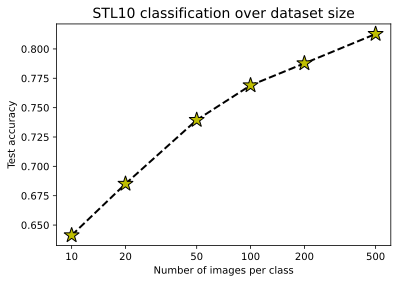

Test accuracy for  10 images per label: 64.12%
Test accuracy for  20 images per label: 68.51%
Test accuracy for  50 images per label: 73.95%
Test accuracy for 100 images per label: 76.90%
Test accuracy for 200 images per label: 78.77%
Test accuracy for 500 images per label: 81.27%


In [23]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

As one would expect, the classification performance improves the more data we have. However, with only 10 images per class, we can already classify more than 60% of the images correctly. This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10. With the full dataset, we achieve an accuracy of 81%. The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset. However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. The implementation of the model is straightforward since the ResNet architecture is provided in the torchvision library.

In [24]:
class ResNet(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [25]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True, transform=train_transforms)

Files already downloaded and verified


The training function for the ResNet is almost identical to the Logistic Regression setup. Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [26]:
def train_resnet(batch_size, lr, weight_decay, max_epochs=100):

    model = ResNet(num_classes=10)
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(max_epochs*0.7), int(max_epochs*0.9)], gamma=0.1)

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)

    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    tlosses = []
    taccs = []
    best_test_acc = 0
    for epoch in range(max_epochs):
        model.train()
        for batch in train_loader:
            losses = []
            accs = []

            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass
            preds = model(imgs)

            # Cross entropy loss
            loss = F.cross_entropy(preds, labels)
            acc = (preds.argmax(dim=-1) == labels).float().mean()

            losses.append(loss.item())
            accs.append(acc.item())

            # Error backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        lr_scheduler.step()

        tlosses.append(np.mean(losses))
        taccs.append(np.mean(accs))

        print(f"Epoch: {epoch}, Train Loss: {tlosses[-1]:.6f}, Train Accuracy: {taccs[-1]:.6f}")

        if epoch%5 == 0:
            ## Test set
            test_acc = []
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    imgs, labels = batch
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    preds = model(imgs)

                    acc = (preds.argmax(dim=-1) == labels).float().mean()
                    test_acc.append(acc.item())

                test_acc = np.mean(test_acc)

                print(f"Epoch: {epoch}, Test Accuracy: {best_test_acc:.6f}")
                if test_acc >= best_test_acc:
                    best_test_acc = test_acc.item()

    return model, best_test_acc

Finally, let's train the model and check its results.

Please note that also in this case, the training procedure is quite long. On Google Colab, it will require approximately ~30 minutes to run.

In [27]:
resnet_model, best_test_acc = train_resnet(batch_size=64,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)

# print(f"Accuracy on training set: {100*train_acc:4.2f}%")
print()

print(f"Accuracy on test set: {100*best_test_acc:4.2f}%")

Epoch: 0, Train Loss: 1.459734, Train Accuracy: 0.468750
Epoch: 0, Test Accuracy: 0.000000
Epoch: 1, Train Loss: 1.646366, Train Accuracy: 0.343750
Epoch: 2, Train Loss: 1.097986, Train Accuracy: 0.625000
Epoch: 3, Train Loss: 1.058360, Train Accuracy: 0.656250
Epoch: 4, Train Loss: 1.151291, Train Accuracy: 0.562500
Epoch: 5, Train Loss: 1.186513, Train Accuracy: 0.593750
Epoch: 5, Test Accuracy: 0.403375
Epoch: 6, Train Loss: 1.069304, Train Accuracy: 0.578125
Epoch: 7, Train Loss: 1.066951, Train Accuracy: 0.546875
Epoch: 8, Train Loss: 0.824223, Train Accuracy: 0.640625
Epoch: 9, Train Loss: 0.790010, Train Accuracy: 0.734375
Epoch: 10, Train Loss: 0.460421, Train Accuracy: 0.843750
Epoch: 10, Test Accuracy: 0.523500
Epoch: 11, Train Loss: 0.773754, Train Accuracy: 0.687500
Epoch: 12, Train Loss: 0.741023, Train Accuracy: 0.734375
Epoch: 13, Train Loss: 0.608797, Train Accuracy: 0.796875
Epoch: 14, Train Loss: 0.432210, Train Accuracy: 0.843750
Epoch: 15, Train Loss: 0.710688, Trai

The ResNet trained from scratch achieves approximately 73% on the test set. This is approximately 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data. This shows that self-supervised, contrastive learning provides considerable performance gains by leveraging large amounts of unlabeled data when little labeled data is available.

## Conclusion

In this last Laboratory, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data. Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al.](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.